# Wyjaśnialne uczenie maszynowe - praca domowa 1

Przygotowanie modelu przewidującego, czy dana osoba jest zamężna

# 1. Import danych

In [270]:
import pandas as pd
import numpy as np

data = pd.read_stata("/home/kasia/Pobrane/HCMST_ver_3.04.dta")

In [271]:
data.head(3)

,caseid_new,weight1,weight2,ppage,ppagecat,ppagect4,ppeduc,ppeducat,ppethm,ppgender,...,w3_mbtiming_year,w3_mbtiming_month,w3_q5,w3_q6,w3_q7,w3_q8,w3_q9,w3_q10,w3_nonmbtiming_year,w3_nonmbtiming_month
0,22526,4265,4265.0,52,45-54,45-59,bachelors degree,bachelor's degree or higher,hispanic,female,...,NaN,NaN,yes,yes,"no, did not marry [xNameP]","No, we have not gotten a domestic partnership ...",NaN,NaN,NaN,NaN
1,23286,16485,16485.0,28,25-34,18-29,masters degree,bachelor's degree or higher,"white, non-hispanic",female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25495,52464,NaN,49,45-54,45-59,high school graduate - high school diploma or ...,high school,"black, non-hispanic",female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Wybranie cech

In [248]:
# Ocena jakości związku 
num1 = "q34"
data[num1].describe()

count          3009
unique            6
top       excellent
freq           1771
Name: q34, dtype: object

In [249]:
# Edukacja (najwyższy zdobyty dyplom)
num2 = "ppeduc"
data[num2].describe()

count                                                  4002
unique                                                   14
top       high school graduate - high school diploma or ...
freq                                                    987
Name: ppeduc, dtype: object

In [250]:
# Czy chodziliście do tej samej szkoły?
cat1 = "q25"
data[cat1].describe()

count                      3009
unique                        3
top       different high school
freq                       2581
Name: q25, dtype: object

In [251]:
# Polityczne preferencje partnera
cat2 = "q12"
data[cat2].describe()

count         3010
unique           6
top       democrat
freq          1276
Name: q12, dtype: object

In [252]:
# Czy jesteście małżeństwem?
label = "s1"
data[label].describe()

count                     4002
unique                       2
top       no, i am not married
freq                      2071
Name: s1, dtype: object

In [253]:
data = data[[num1,num2,cat1,cat2,label]].dropna()
data.rename(columns={'q34':'rel_quality','ppeduc':'education','q25':'same_school','q12':'partner_politics'}, inplace=True)
data.head()

,rel_quality,education,same_school,partner_politics,s1
0,good,bachelors degree,different high school,democrat,"no, i am not married"
1,good,masters degree,different high school,democrat,"yes, i am married"
3,good,associate degree,different high school,democrat,"no, i am not married"
6,good,bachelors degree,different high school,democrat,"no, i am not married"
7,good,masters degree,different high school,democrat,"yes, i am married"


# 3. Preprocessing

In [254]:
from sklearn import preprocessing
    
le = preprocessing.LabelEncoder()

for column_name in data.columns:
    if column_name == "rel_quality":
        data[column_name] = data[column_name].map({
            'refused':-1, 
            'excellent':5, 
            "good":4, 
            "fair":3, 
            "poor":2, 
            "very poor":1
        })
    
    if column_name == "education":
        data[column_name] = data[column_name].map({
            'no formal education':1, 
            '1st, 2nd, 3rd, or 4th grade':2, 
            '5th or 6th grade':3,
            '7th or 8th grade':4,
            '9th grade':5,
            '10th grade':6,        
            '11th grade':7, 
            '12th grade no diploma':8,
            'high school graduate - high school diploma or the equivalent (ged)':9,
            'some college, no degree':10,
            'bachelors degree':11,
            'masters degree':12,
            'associate degree':13,
            'professional or doctorate degree':14, 
        })
    
    if column_name != 'rel_quality' and column_name != 'education' and hasattr(pd.Series(data[column_name], dtype='category'), 'cat'):
        data[column_name] = le.fit_transform(data[column_name].astype(str))
    else:
        pass

   

In [255]:
data.head()

,rel_quality,education,same_school,partner_politics,s1
0,4,11,0,1,0
1,4,12,0,1,1
3,4,13,0,1,0
6,4,11,0,1,0
7,4,12,0,1,1


# 4. Podział zbioru danych na treningowy i testowy

In [256]:
y = data.loc[:,'s1']

In [257]:
X = data.loc[:, data.columns != 's1']

In [258]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [259]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2016, 4), (993, 4), (2016,), (993,))

# 5. Przygotowanie modelu

In [260]:
from sklearn import svm
from sklearn.metrics import accuracy_score

model = svm.SVC(gamma='scale', probability=True)

y_pred = model.fit(X_train,y_train).predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("Model accuracy score: " + str(acc))

Model accuracy score: 0.6465256797583081


# 6. Wykres Ceteris Paribus

# Wybranie próbki:

In [261]:
sample = X_test.sample(1)
print(sample)
sample.values

      rel_quality  education  same_school  partner_politics
3771            5         10            0                 3


array([[ 5, 10,  0,  3]])

In [272]:
X_temp = X_train.copy()
X_temp.loc[:,'same_school'] = int(sample['same_school'])
X_temp.loc[:,'partner_politics'] = int(sample['partner_politics'])
X_temp.loc[:,'rel_quality'] = int(sample['rel_quality'])
X_temp.loc[:,'education'] = int(sample['education'])

X_temp.head()

,rel_quality,education,same_school,partner_politics
2098,5,10,0,3
3631,5,10,0,3
1528,5,10,0,3
1129,5,10,0,3
1109,5,10,0,3


# Wykresy dla wybranych cech numerycznych

In [264]:
import matplotlib.pyplot as plt

def ceteris_paribus_plot(subject,num_feature,n):
    X_temp_1 = X_temp.copy().head(n)
    
    f_min, f_max = data[num_feature].min(), data[num_feature].max()
    start, stop = (f_min, f_max)
    num_feature_values = np.linspace(start, stop, n, dtype=int)
    
    X_temp_1[num_feature] = num_feature_values
    
    y_pred = model.predict_proba(X_temp_1)[:, 1]
    
    plt.plot(num_feature_values, y_pred)
    plt.xlabel(subject)
    plt.ylabel("Prawdopodobieństwo bycia małżeństwem")

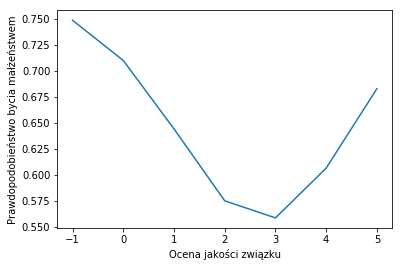

In [267]:
ceteris_paribus_plot("Ocena jakości związku",'rel_quality',500)

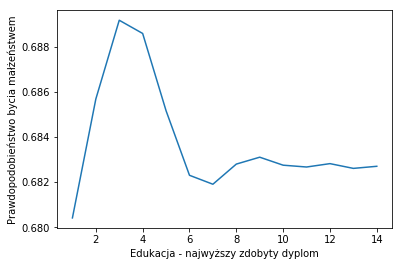

In [268]:
ceteris_paribus_plot("Edukacja - najwyższy zdobyty dyplom",'education',500)